In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import datetime
from dateutil.relativedelta import relativedelta
#import seaborn as sns
import statsmodels.tsa.statespace.sarimax# .SARIMAX
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

In [2]:
from statsmodels.graphics.api import qqplot

In [3]:
import statsmodels
print(statsmodels.__version__)

0.8.0rc1


(0, 150)

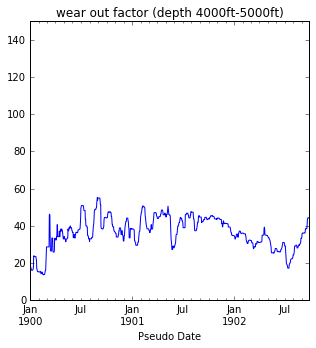

In [43]:
rawdata = pd.read_csv('metrics_medfil_12_30_2016.csv')
rawdata_select = rawdata[2000:3000]
data_full = pd.DataFrame({'wear_factor':list(rawdata_select['Wear_factor_medfil'])},index=pd.date_range(start='01/01/1900', periods=len(rawdata_select))) 


#plot the data
fig, ax = plt.subplots(figsize=(5,5))
ax.set(title='wear out factor (depth 4000ft-5000ft)', xlabel='Pseudo Date', ylabel='')
data_full.ix[:,'wear_factor'].plot(ax=ax,label='Observed')
#data_train_validate.ix[:,'wear_factor'].plot(ax=ax,style='r',label='training and validation set')
#data_training.ix[:,'wear_factor'].plot(ax=ax,style='g',label='training set')
#print(len(data_full))
plt.ylim([0,150])

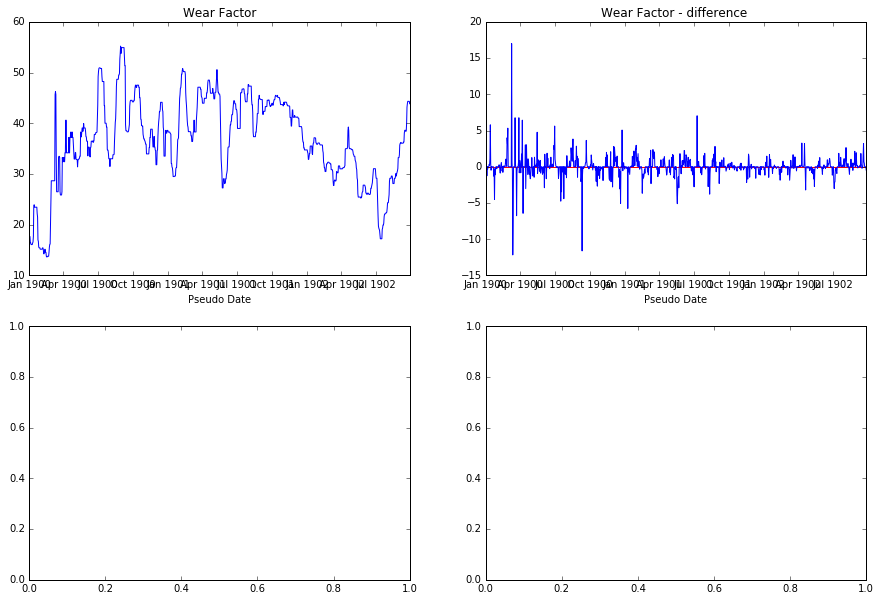

In [44]:
# pre-processing of data
data_full['diff_wear_factor']=data_full['wear_factor'].diff()
data_full['log_wear_factor'] = np.log(data_full['wear_factor'])
data_full['diff_log_wear_factor'] = data_full['log_wear_factor'].diff()

# Graph data
fig, axes = plt.subplots(2, 2, figsize=(15,10))

# Levels
axes[0][0].plot(data_full.index._mpl_repr(), data_full['wear_factor'], '-')
axes[0][0].set(xlabel='Pseudo Date',title='Wear Factor')

#  difference
axes[0][1].plot(data_full.index._mpl_repr(), data_full['diff_wear_factor'], '-')
axes[0][1].hlines(0, data_full.index[0], data_full.index[-1], 'r')
axes[0][1].set(xlabel='Pseudo Date',title='Wear Factor - difference ');

# Log
#axes[1][0].plot(data_full.index._mpl_repr(), data_full['log_wear_factor'], '-')
#axes[1][0].hlines(0, data_full.index[0], data_full.index[-1], 'r')
#axes[1][0].set(title='US Wholesale Price Index - difference of logs');

# Log difference
#axes[1][1].plot(data_full.index._mpl_repr(), data_full['diff_log_wear_factor'], '-')
#axes[1][1].hlines(0, data_full.index[0], data_full.index[-1], 'r')
#axes[1][1].set(title='US Wholesale Price Index - difference of logs');

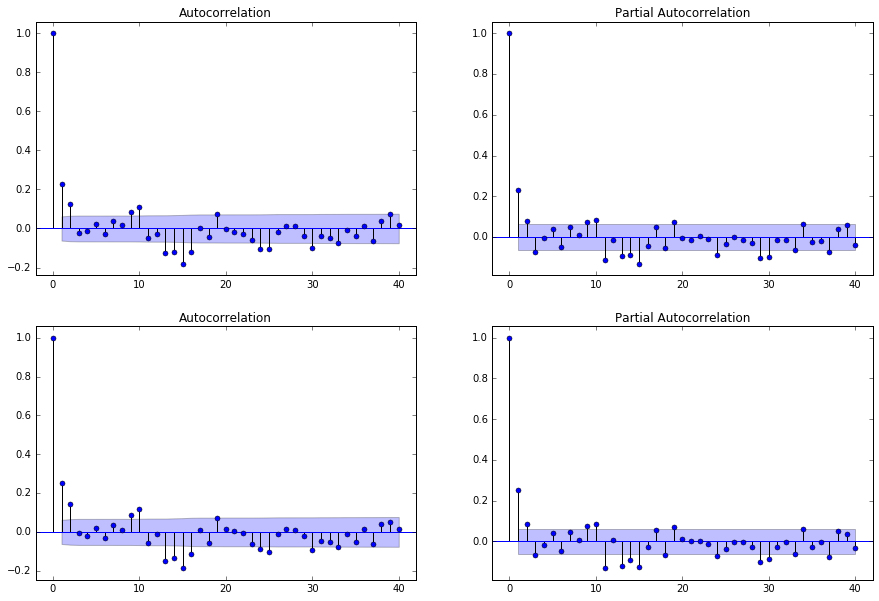

In [46]:
# Graph data
fig, axes = plt.subplots(2, 2, figsize=(15,10))
fig = sm.graphics.tsa.plot_acf(data_full.ix[1:, 'diff_wear_factor'], lags=40, ax=axes[0][0])
fig = sm.graphics.tsa.plot_pacf(data_full.ix[1:, 'diff_wear_factor'], lags=40, ax=axes[0][1])

fig = sm.graphics.tsa.plot_acf(data_full.ix[1:, 'diff_log_wear_factor'], lags=40, ax=axes[1][0])
fig = sm.graphics.tsa.plot_pacf(data_full.ix[1:, 'diff_log_wear_factor'], lags=40, ax=axes[1][1])

In [35]:
#select the traning set
data_train_validate = data_full.ix[:len(data_full)-50,'wear_factor']
data_training = data_full.ix[:len(data_full)-100,'wear_factor']
#print(data_training)
# Fit the model
mod =statsmodels.tsa.arima_model.ARIMA(data_training[:].dropna(inplace=False),order=(3,1,0))
#log_mod =statsmodels.tsa.arima_model.ARIMA(data_training[:].dropna(inplace=False),order=(2,1,0))
fit_res = mod.fit()
#log_fit_res = log_mod.fit()
#print(fit_res.summary())

#resid = fit_res.resid 
#log_resid = log_fit_res.resid 
#stats.normaltest(resid)
#print(fit_res.summary())
#print(log_fit_res.summary())
print(fit_res.params)

const                  0.062893
ar.L1.D.wear_factor    0.256680
ar.L2.D.wear_factor    0.084416
ar.L3.D.wear_factor    0.105792
dtype: float64


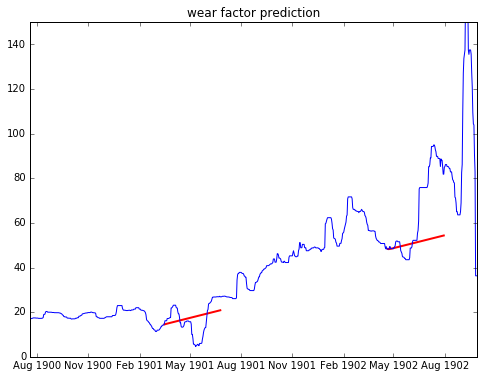

In [42]:
startpoint1 = 440
endpoint1 = 540
startpoint2 = 840
endpoint2 = 940
predict1 = fit_res.predict(startpoint1,endpoint1, dynamic=True) # training 700, train_validate 750 test 800
predict2 = fit_res.predict(startpoint2,endpoint2, dynamic=True) # training 700, train_validate 750 test 800

#print(predict_dy_ci)
data_full_shift = data_full['wear_factor'].shift(1)
data_full_shift[0]=data_full['wear_factor'][1]
data_full_shift[1] =data_full_shift[0] 
#print(predict.head(),data_full_shift[600:602])
#data_full_shift
predict_org1 = data_full_shift[startpoint1]+ np.cumsum(predict1[:]) #+ data_full_shift[600:750]
predict_org2 = data_full_shift[startpoint2]+ np.cumsum(predict2[:]) #+ data_full_shift[600:750]
#predict_org_ci_0 = data_full_shift[startpoint]+ np.cumsum(predict) + p
#predict_dy_ci
predict_org1.head()

#predict_org = predict + predict
fig, ax = plt.subplots(figsize=(8, 6))
#ax = data_train_validate.ix[startpoint:endpoint].plot(ax=ax)
plt.plot(predict_org1,'r',linewidth=2)
plt.plot(predict_org2,'r',linewidth=2)
plt.plot(data_full['wear_factor'][200:])
#plt.plot(data_full['wear_factor'][startpoint-20:endpoint+20],'.')
ax.set_ylim([0, 150])
ax.set_title('wear factor prediction')

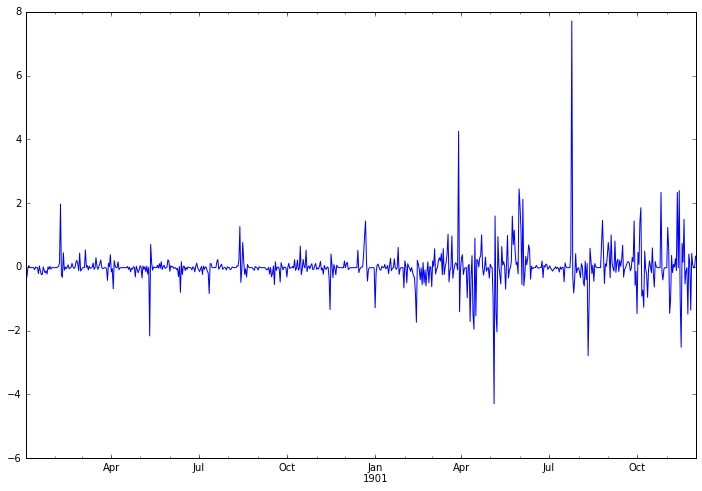

In [157]:
resid = fit_res
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = fit_res.resid.plot(ax=ax);

TypeError: float() argument must be a string or a number, not 'ARIMAResultsWrapper'

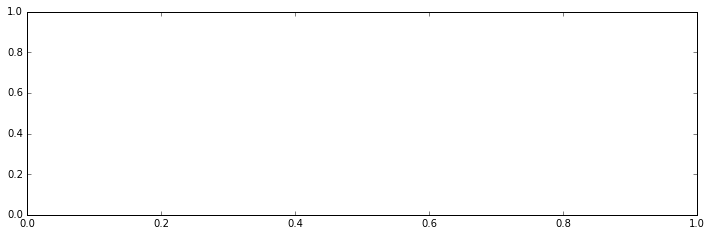

In [159]:
fig = plt.figure(figsize=(12,8))
#ax1 = fig.add_subplot(211)
#fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [189]:
a = np.array([1,2,3,4])
b = a+1
data_full_shift[600]

29.671050834250909

9229


(0, 100)

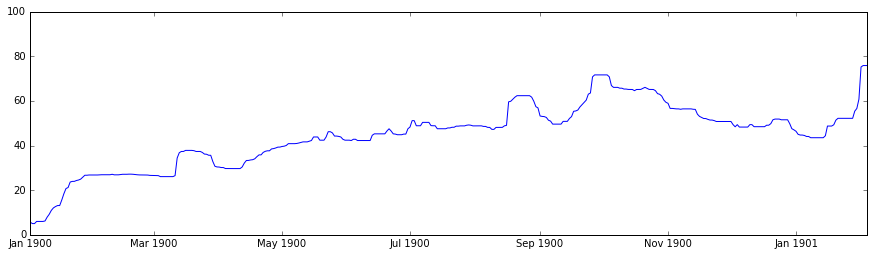

In [69]:
#rawdata = pd.read_csv('metrics_medfil_12_30_2016.csv')


ts = pd.DataFrame({'data':list(mydata['Wear_factor_medfil'])},index=pd.date_range(start='01/01/1900', periods=len(mydata))) 
ts['1900':'1902']
fig = plt.figure(figsize=(15,4),dpi=600)
plt.plot(ts['data'])
plt.ylim([0,100])

In [42]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()
    #plot 
    fig = plt.figure(figsize=(15,4),dpi=600)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    #plt.show(block=False)
    


    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Test Statistic                   0.396011
p-value                          0.981345
#Lags Used                      14.000000
Number of Observations Used    465.000000
Critical Value (10%)            -2.570091
Critical Value (1%)             -3.444491
Critical Value (5%)             -2.867776
dtype: float64


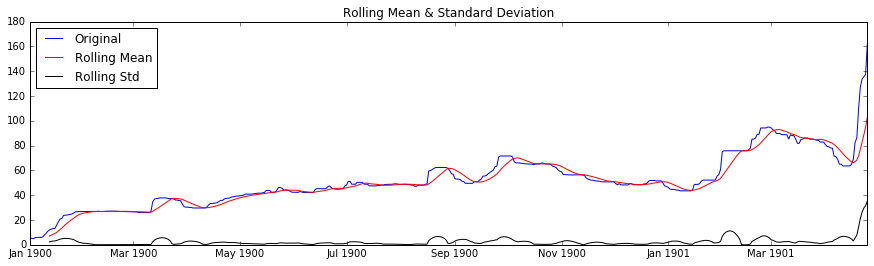

In [43]:
test_stationarity(ts['data'])

C:\Users\hj5446\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(min_periods=0,halflife=12,adjust=True,ignore_na=False).mean()
  from ipykernel import kernelapp as app


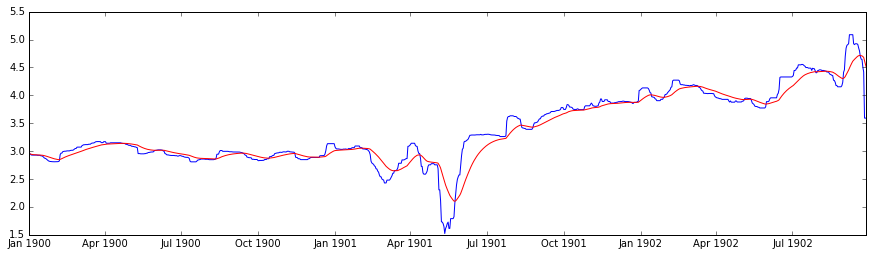

In [57]:
ts_log = np.log(ts)
expwighted_avg = pd.ewma(ts_log, halflife=12)
fig = plt.figure(figsize=(15,4),dpi=600)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')


Test Statistic                -8.635724e+00
p-value                        5.597950e-14
#Lags Used                     2.000000e+00
Number of Observations Used    3.960000e+02
Critical Value (10%)          -2.570673e+00
Critical Value (1%)           -3.446972e+00
Critical Value (5%)           -2.868866e+00
dtype: float64


(-50, 50)

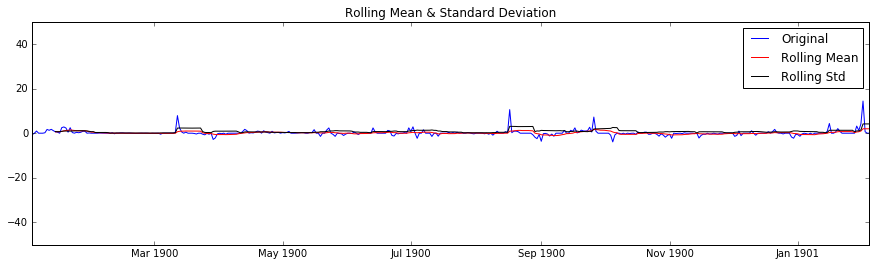

In [74]:
ts['first_difference'] = ts['data'] - ts['data'].shift(1)  
ts['second_difference'] = ts['first_difference'] - ts['first_difference'].shift(1)

test_stationarity(ts['first_difference'].dropna(inplace=False))
plt.ylim([-50,50])

Test Statistic                  -4.446554
p-value                          0.000245
#Lags Used                       3.000000
Number of Observations Used    446.000000
Critical Value (1%)             -3.445097
Critical Value (10%)            -2.570233
Critical Value (5%)             -2.868042
dtype: float64


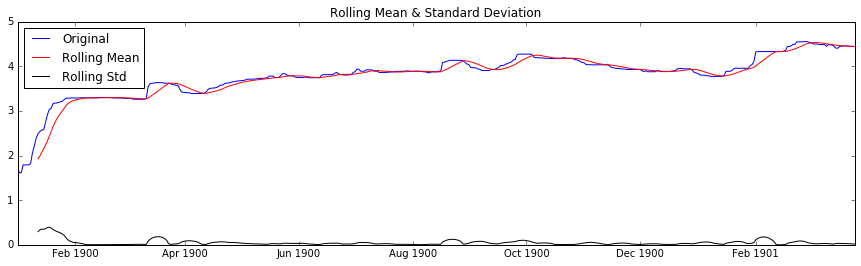

In [91]:
ts['data_log']= ts['data'].apply(lambda x: np.log(x))  
test_stationarity(ts['data_log'])


Test Statistic                -7.357586e+00
p-value                        9.688689e-11
#Lags Used                     2.200000e+01
Number of Observations Used    9.760000e+02
Critical Value (1%)           -3.437068e+00
Critical Value (10%)          -2.568349e+00
Critical Value (5%)           -2.864506e+00
dtype: float64


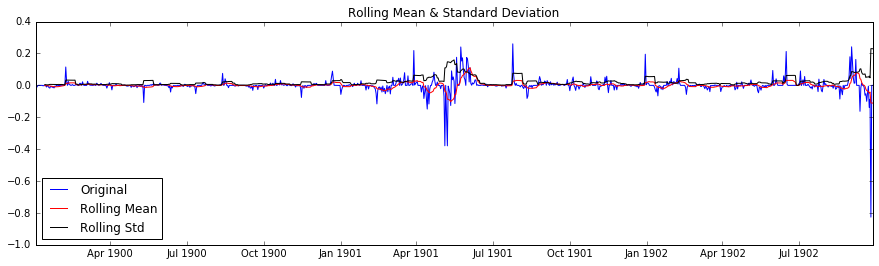

In [60]:
ts['log_first_difference'] = ts['data_log'] - ts['data_log'].shift(1)  
test_stationarity(ts.log_first_difference.dropna(inplace=False))
#plt.ylim([-50,50])

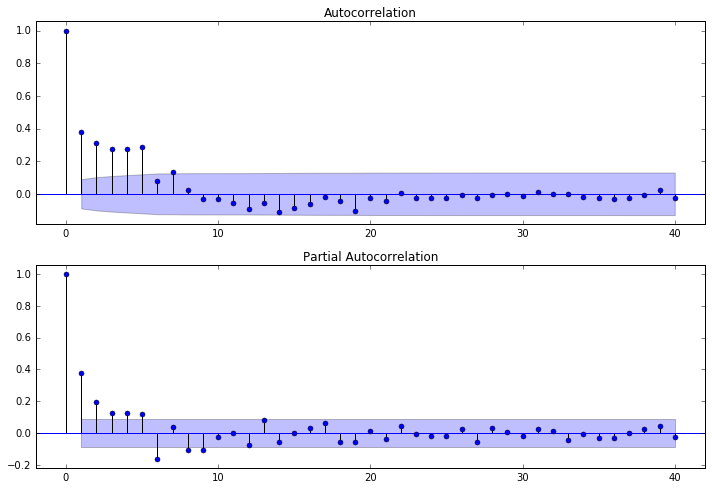

In [45]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts['first_difference'].iloc[1:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts['first_difference'].iloc[1:], lags=40, ax=ax2)

                             ARIMA Model Results                              
Dep. Variable:                 D.data   No. Observations:                  399
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -660.811
Method:                       css-mle   S.D. of innovations              1.268
Date:                Wed, 11 Jan 2017   AIC                           1329.621
Time:                        14:30:20   BIC                           1345.577
Sample:                    01-02-1900   HQIC                          1335.941
                         - 02-04-1901                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1771      0.113      1.571      0.117      -0.044       0.398
ar.L1.D.data     0.6892      0.118      5.865      0.000       0.459       0.920
ma.L1.D.data    -0.4463      0.147     -3.03

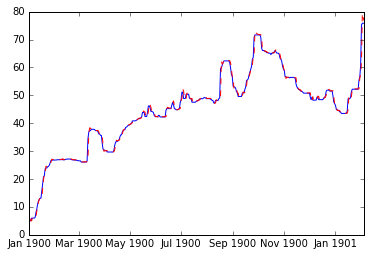

In [112]:
#mod = statsmodels.tsa.statespace.sarimax.SARIMAX([[1,2,3],[2,3,4]], trend='n', order=(0,1,0))
#results = mod.fit()
#
#mod = statsmodels.tsa.arima_model.ARMA(ts['first_difference'].dropna(inplace=False),order=(1,0))
mod =statsmodels.tsa.arima_model.ARIMA(ts['data'].dropna(inplace=False),order=(2,1,0))
results = mod.fit()
print(results.summary())
#plt.plot(ts['first_difference'])
#plt.plot(results.fittedvalues, color='red')


ts['orginial_prediction'] = results.fittedvalues + ts['data'].shift(1)
plt.plot(ts['data'])
plt.plot(ts['orginial_prediction'] , '--r')
#rss = sum((results.fittedvalues.dropna(inplace=False)-ts['first_difference'].dropna(inplace=False)**2))
#plt.title('RSS: %.4f'% rss)

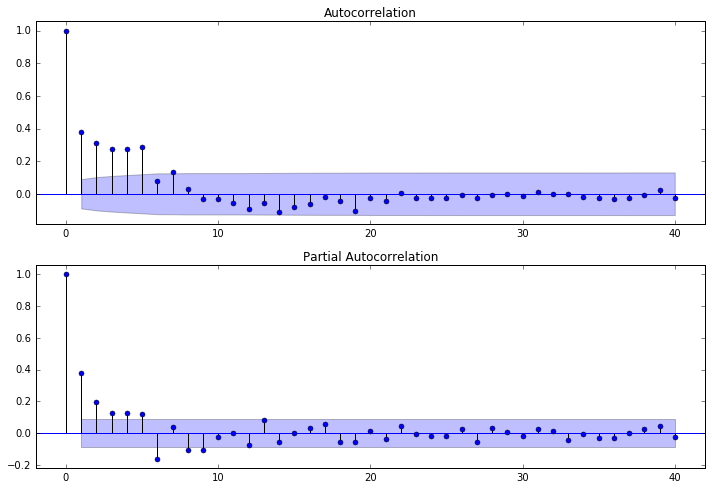

In [61]:
ts['residual'] = ts['first_difference'] - ts['forecast'] 
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts['residual'].iloc[3:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts['residual'].iloc[3:], lags=40, ax=ax2)

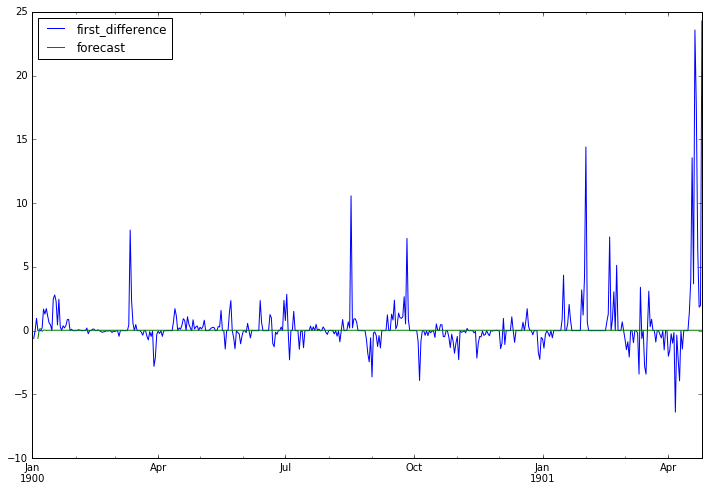

In [63]:
ts['forecast'] = results.predict(start =3 , end= len(ts), dynamic= True)  
plt.plot(ts['data'])
plt.plot(ts['orginial_prediction'] , color='red')
#ts['forecast_exp']=np.exp(ts['forecast'])
ts[['first_difference', 'forecast']].plot(figsize=(12, 8)) 

In [90]:
test = pd.DataFrame([1,2,3,4],columns=['a'])
test['b'] = test['a']-test['a'].shift(1)
test['d']=test['b'] + test['a'].shift(1)


,a,b,d
0,1,NaN,NaN
1,2,1.0,2.0
2,3,1.0,3.0
3,4,1.0,4.0
